In [5]:
from sklearn import datasets
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import (
    DataDriftTab,
    CatTargetDriftTab
)
from evidently.model_profile import Profile
from evidently.model_profile.sections import (
    DataDriftProfileSection,
    CatTargetDriftProfileSection
)


def change_column(_df, col_name):
    _df = _df[_df['Moneda'] == col_name].copy()
    return _df.rename({'Moneda': col_name}, axis=1)
    
df = pd.read_csv('all_messages_rates.csv')
df['Fecha'] = pd.to_datetime(df['Fecha'])
df.set_index('Fecha', inplace=True)
df.sort_index(inplace=True)
df = df[df.index > '2022'][['Mediana', 'Moneda']]

# _df_mlc = change_column(df, 'MLC')
# _df_usd = change_column(df, 'USD')
# _df_ecu = change_column(df, 'ECU')
# df = pd.concat([_df_usd, _df_mlc, _df_ecu], axis=1, ignore_index=True)

In [6]:
report = Dashboard(tabs=[DataDriftTab()])
january = df[df.index < datetime(2022, 1, 15)]
february = df[(df.index > datetime(2022, 1, 15)) & (df.index < datetime(2022, 2, 1))]


In [7]:
report.calculate(january, february, column_mapping = None)
report.save("reports/my_report.html")

In [112]:
df = df.reset_index()
a = df.pivot(columns='Moneda')
new_df = pd.DataFrame()
new_df.loc[:, 'Date'] = a['Fecha'].max(1)
new_df.loc[:, 'MLC'] = a['Mediana']['MLC']
new_df.loc[:, 'ECU'] = a['Mediana']['ECU']
new_df.loc[:, 'USD'] = a['Mediana']['USD']
new_df = new_df.set_index('Date')


In [113]:
january = new_df[new_df.index < datetime(2022, 1, 15)]
february = new_df[(new_df.index > datetime(2022, 1, 15)) & (new_df.index < datetime(2022, 2, 1))]
report.calculate(january, february, column_mapping = None)
report.save("reports/my_report.html")

In [114]:
new_df = new_df.resample('d').std()

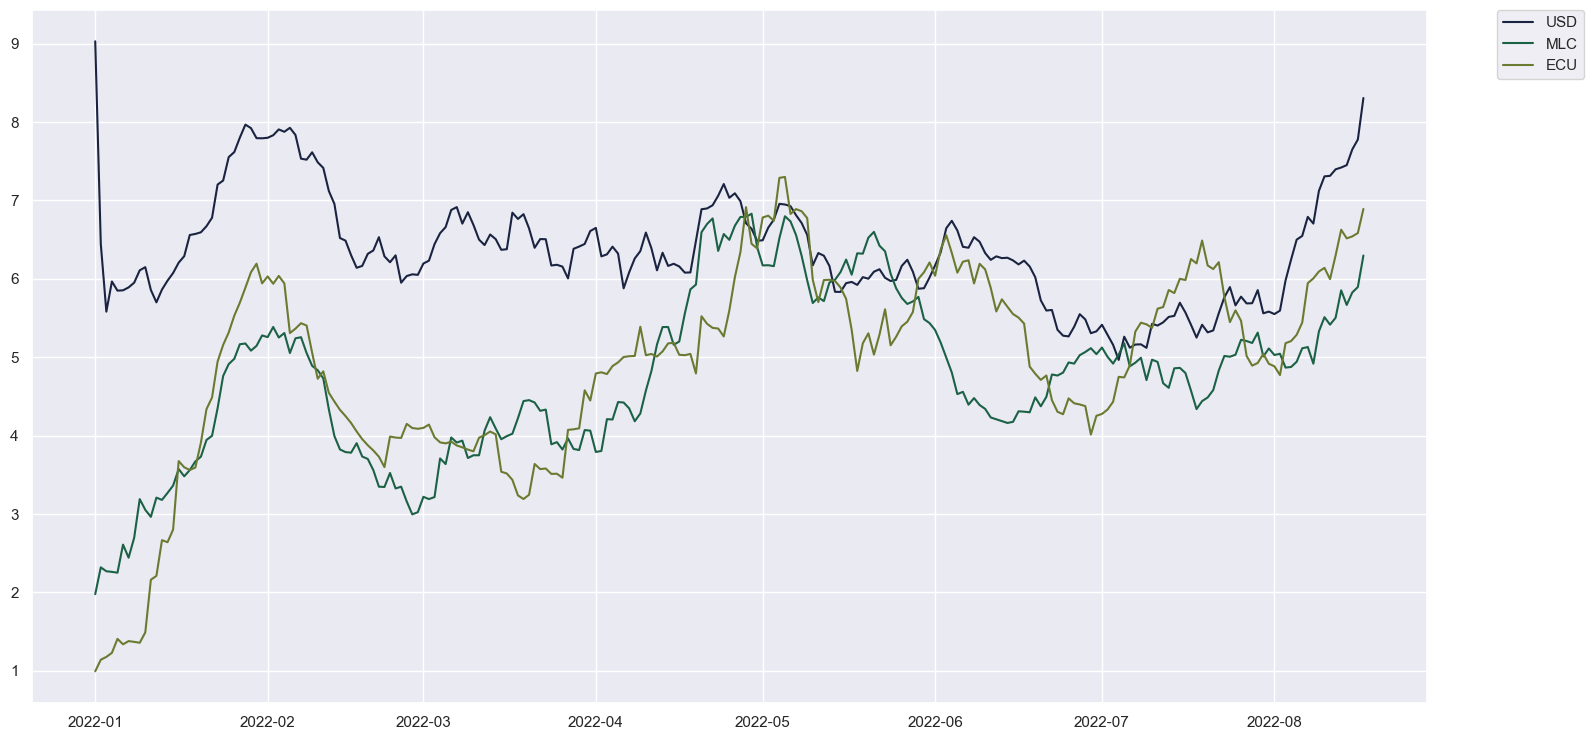

In [115]:
import matplotlib.pyplot as plt
# df['USD'] = new_df[new_df['USD'] > 50]
plt.plot(new_df['USD'].rolling(20, min_periods=1).mean().dropna(), label="USD")
plt.plot(new_df['MLC'].rolling(20, min_periods=1).mean().dropna(), label="MLC")
plt.plot(new_df['ECU'].rolling(20, min_periods=1).mean().dropna(), label="ECU")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [12]:
import statsmodels.tsa.stattools as st

"""
Augmented Dickey-Fuller (ADF):
ADF test says that, if a series possesses mean reversion, then the next value level will be proportional to the current price level.
Mathematically, the ADF is based on the idea of testing for the presence of a unit root in an autoregressive time series sample.
"""
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = st.adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 
              'pvalue': round(r[1], 4), 
              'n_lags':round(r[2], 4), 
              'n_obs':r[3]} 
    
    p_value = output['pvalue']
    
    def adjust(val, length= 6): 
        return str(val).ljust(length)

    print(f'Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f'Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f'Significance Level = {signif}')
    print(f'Test Statistic = {output["test_statistic"]}')
    print(f'No. Lags Chosen = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')
        if p_value <= signif:
            print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
            print(f" => Series is Stationary.")
        else:
            print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
            print(f" => Series is Non-Stationary.")
            
    print()

In [13]:
for name, col in new_df.iteritems():
    adfuller_test(col, name=name)

Augmented Dickey-Fuller Test on "MLC" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -1.8792
No. Lags Chosen = 15
 Critical value 1%     = -3.461
 => P-Value = 0.3419. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
 Critical value 5%     = -2.875
 => P-Value = 0.3419. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
 Critical value 10%    = -2.574
 => P-Value = 0.3419. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.

Augmented Dickey-Fuller Test on "ECU" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -2.2661
No. Lags Chosen = 5
 Critical value 1%     = -3.46
 => P-Value = 0.1831. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.
 Critical value 5%     = -2.875
 => P-Value = 0.1831.

In [46]:
from statsmodels.tsa.stattools import coint
coint(new_df['USD'], new_df['MLC'])

(-2.6037661195270467,
 0.23531510105012593,
 array([-3.9451196 , -3.36305994, -3.06310408]))

In [48]:
import statsmodels.formula.api as smf

formula = 'USD ~ MLC + ECU'
r = smf.ols(formula, new_df).fit()
print(r.summary())

                            OLS Regression Results                            
Dep. Variable:                    USD   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     985.1
Date:                Tue, 20 Sep 2022   Prob (F-statistic):          2.54e-112
Time:                        14:35:23   Log-Likelihood:                -624.77
No. Observations:                 229   AIC:                             1256.
Df Residuals:                     226   BIC:                             1266.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.8278      3.614     -3.273      0.0

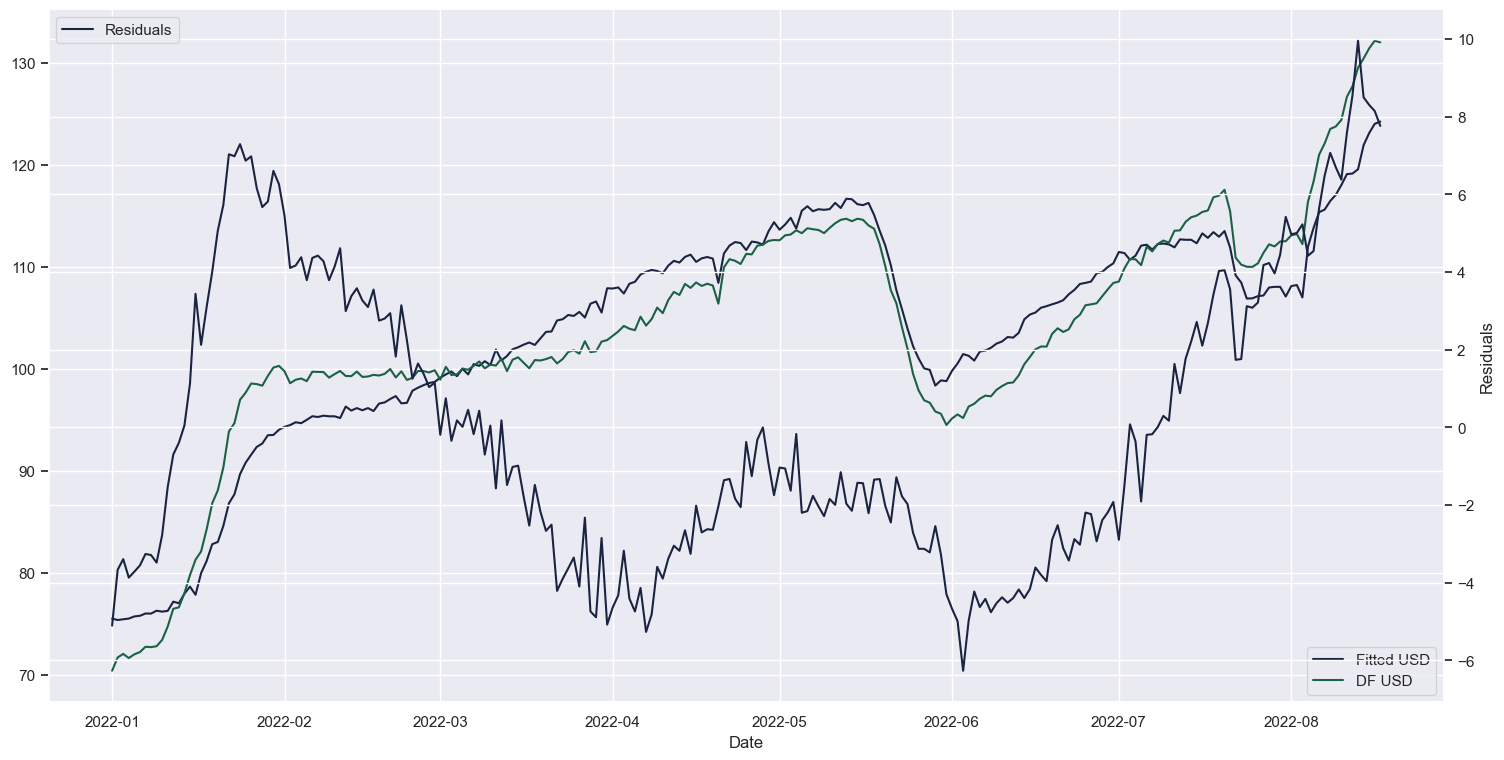

In [52]:
residuals = r.resid
usd_fit = r.fittedvalues
fig = plt.figure(1)
ax1 = fig.add_subplot(111)
ax1.plot(usd_fit, label='Fitted USD')
ax1.plot(new_df['USD'], label='DF USD')
ax1.set_xlabel('Date')
ax1.legend(loc=4)
ax2 = plt.twinx()
ax2.set_ylabel('Residuals')
ax2.plot(residuals, label='Residuals')
ax2.legend(loc=0)
plt.grid(True)
plt.show()

In [53]:
per_month = new_df.resample('M').mean()

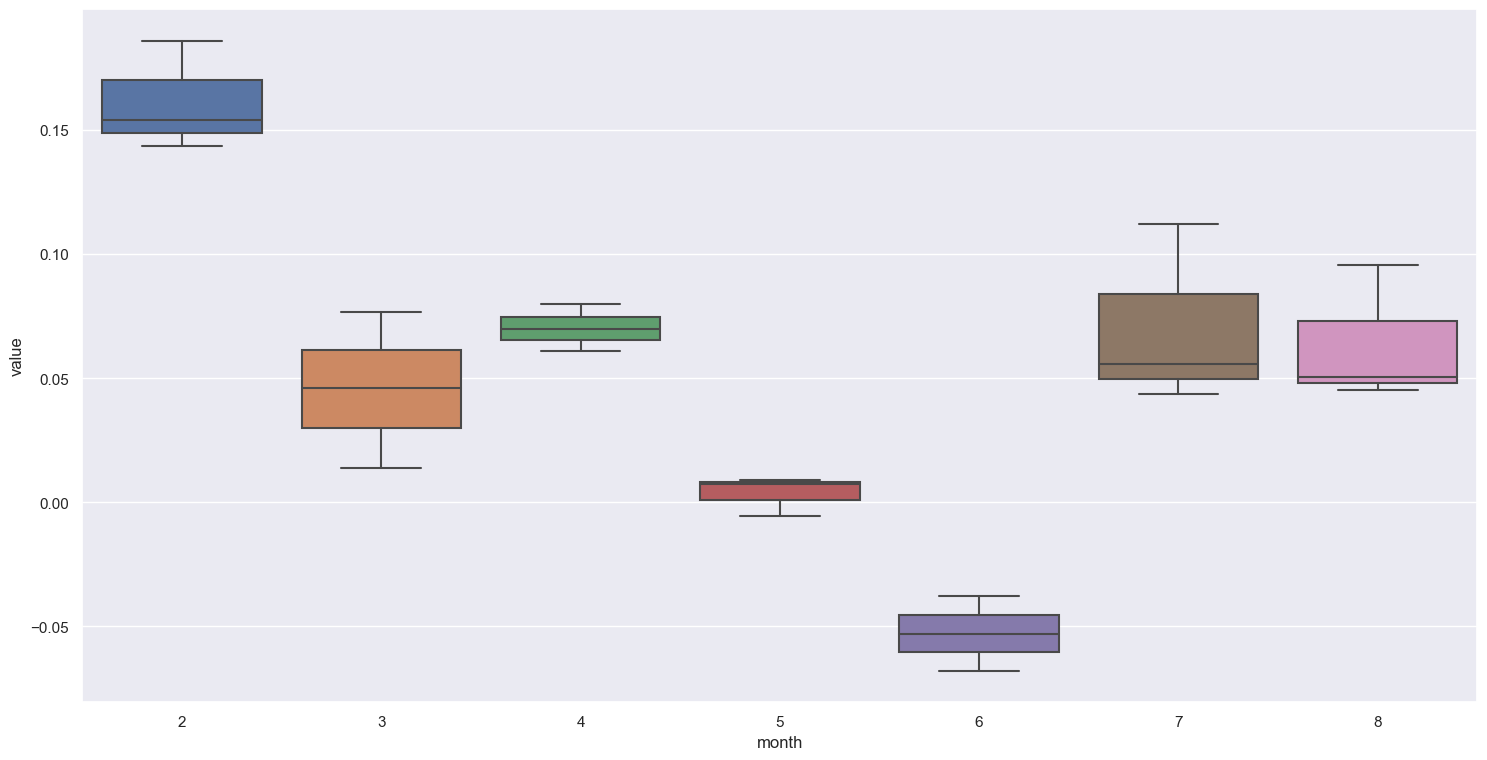

In [54]:
import seaborn as sns
monthly_diff = per_month.pct_change().dropna()
monthly_diff['month'] = monthly_diff.index.month
monthly_diff = monthly_diff.melt('month')
sns.set(rc={'figure.figsize':(18, 9)})
sns.boxplot(data=monthly_diff, x='month', y='value')
plt.title("")
plt.suptitle("")
plt.show()

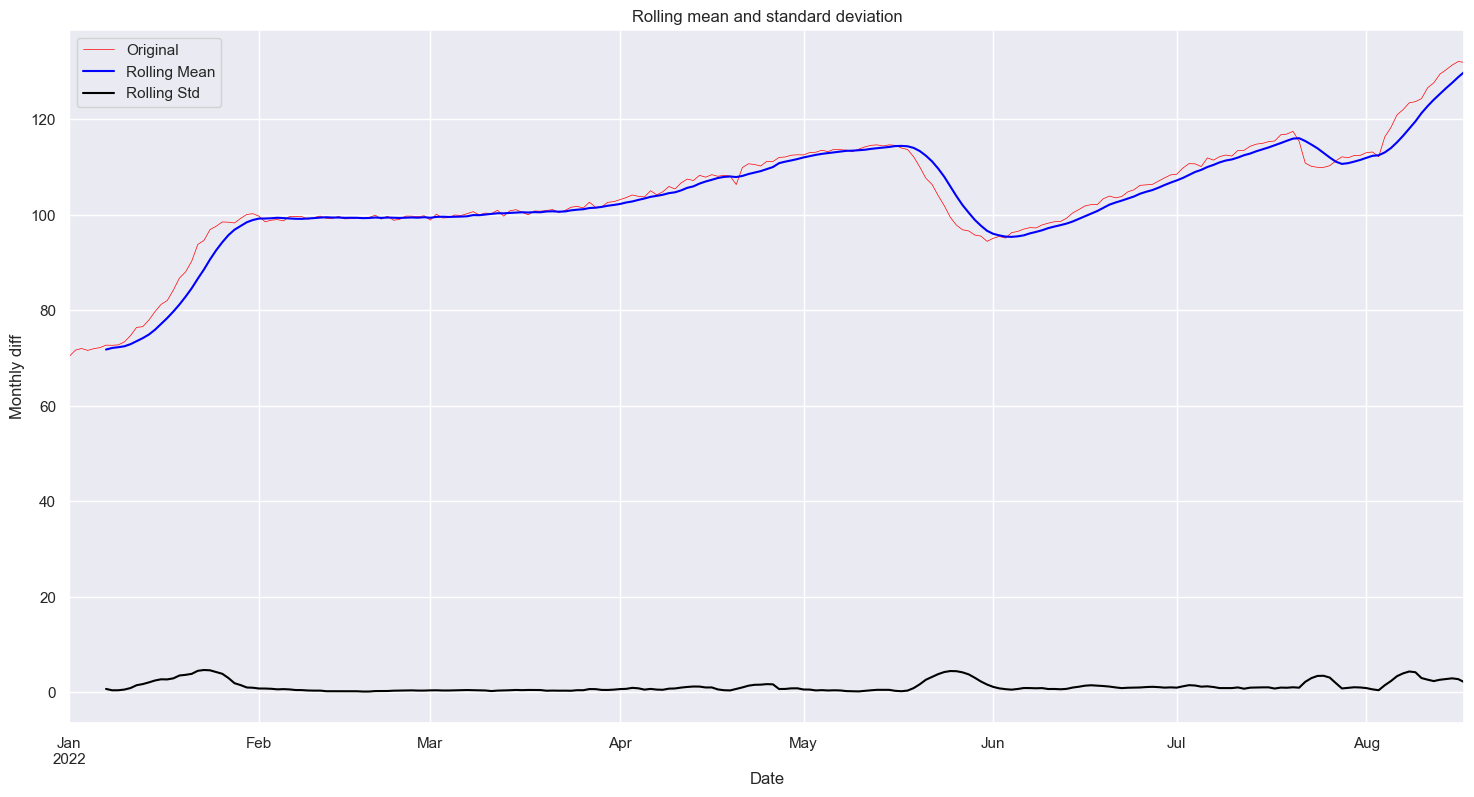

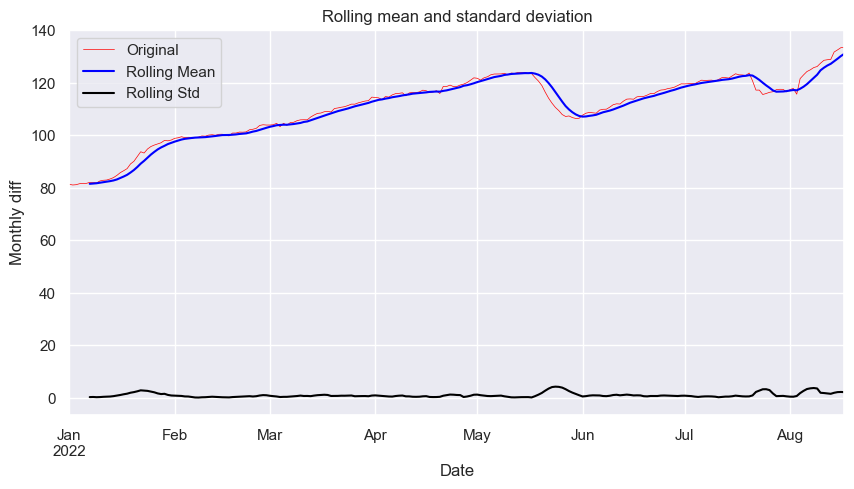

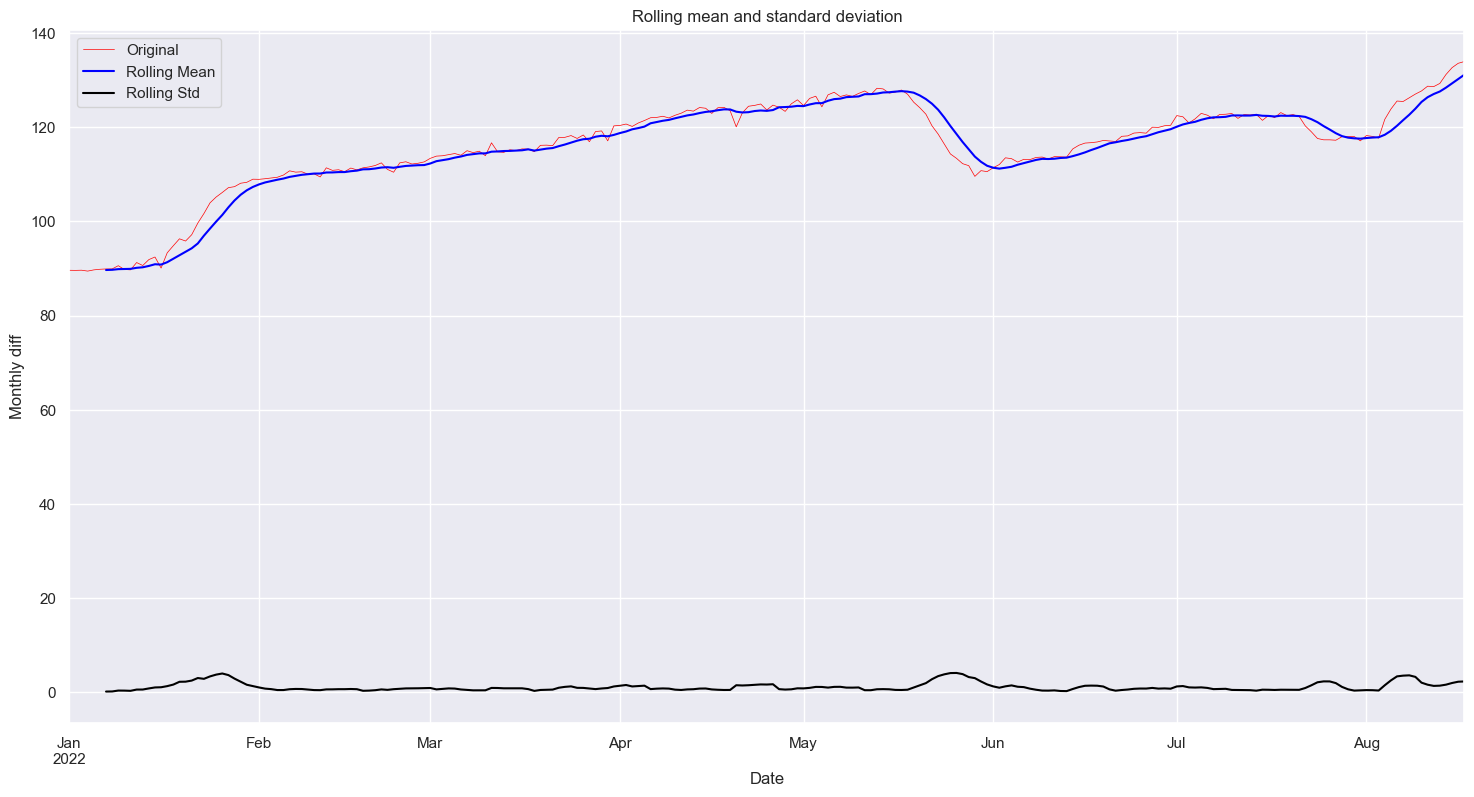

In [55]:
def plot_rolling_statistics_ts(ts, titletext, ytext, window_size=7):
    ts.plot(color='red', label='Original', lw=0.5)
    ts.rolling(window_size).mean().plot(color='blue',label='Rolling Mean')
    ts.rolling(window_size).std().plot(color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.ylabel(ytext)
    plt.title(titletext)
    plt.show(block=False)

plot_rolling_statistics_ts(new_df['USD'],
                           'Rolling mean and standard deviation',
                           'Monthly diff')
plt.figure(figsize=(10,5))
plot_rolling_statistics_ts(new_df['MLC'],
                           'Rolling mean and standard deviation',
                           'Monthly diff')

plot_rolling_statistics_ts(new_df['ECU'],
                           'Rolling mean and standard deviation',
                           'Monthly diff')

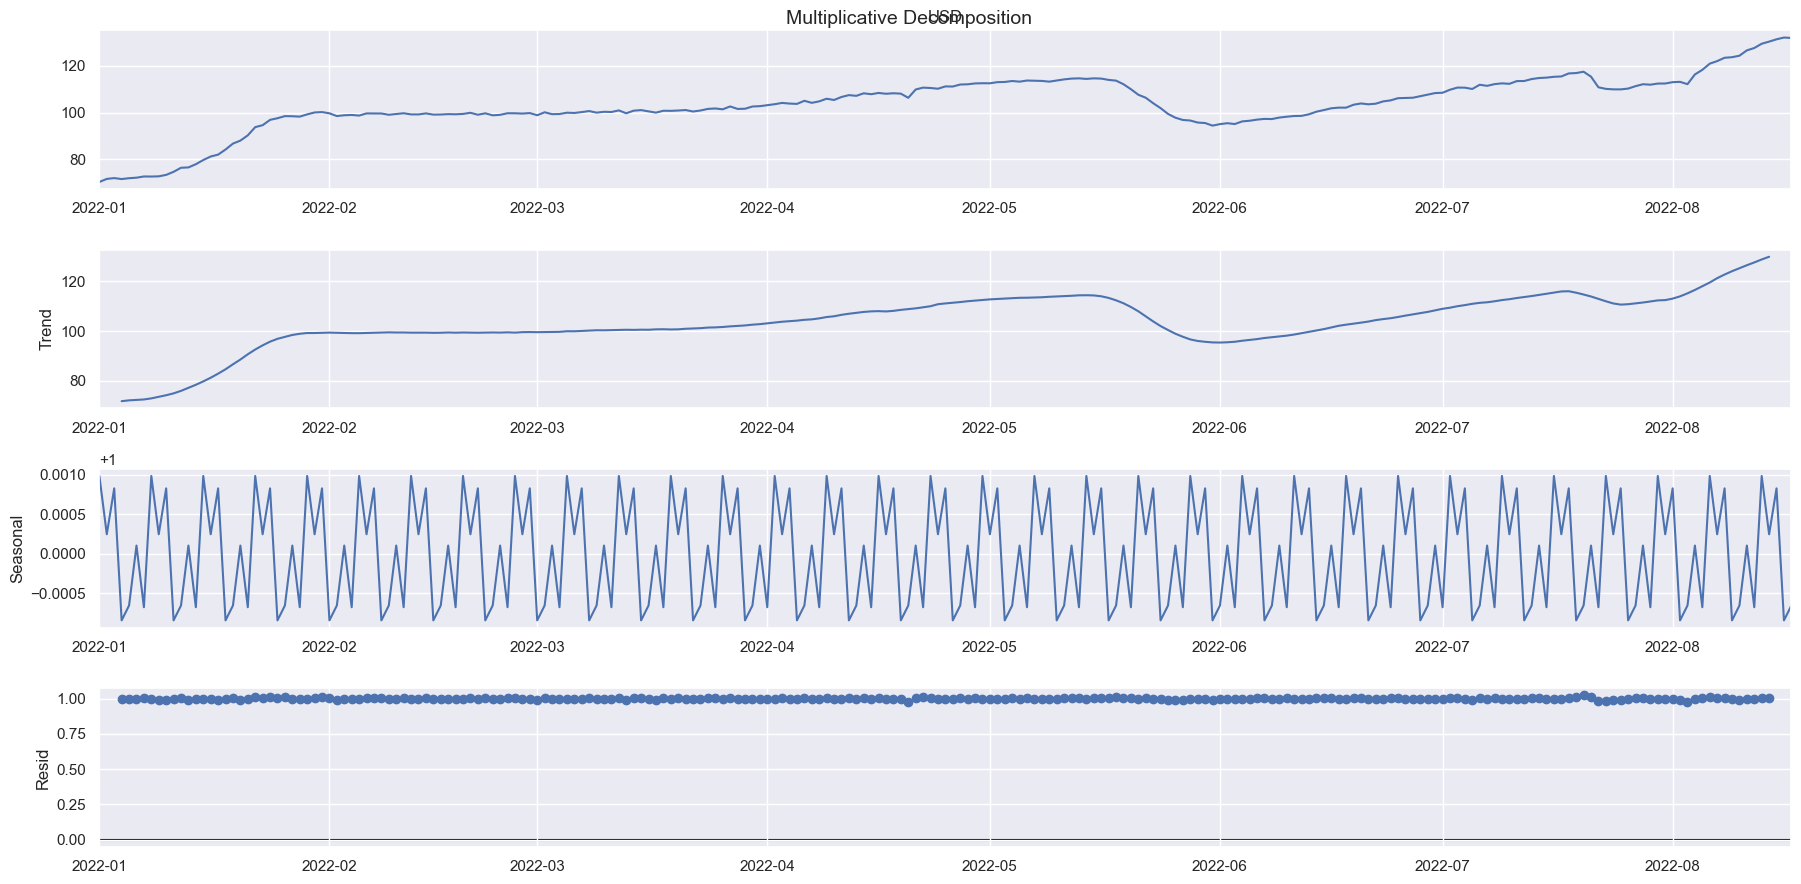

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(new_df['USD'], model='multiplicative')
decomp.plot().suptitle('Multiplicative Decomposition', fontsize=14);

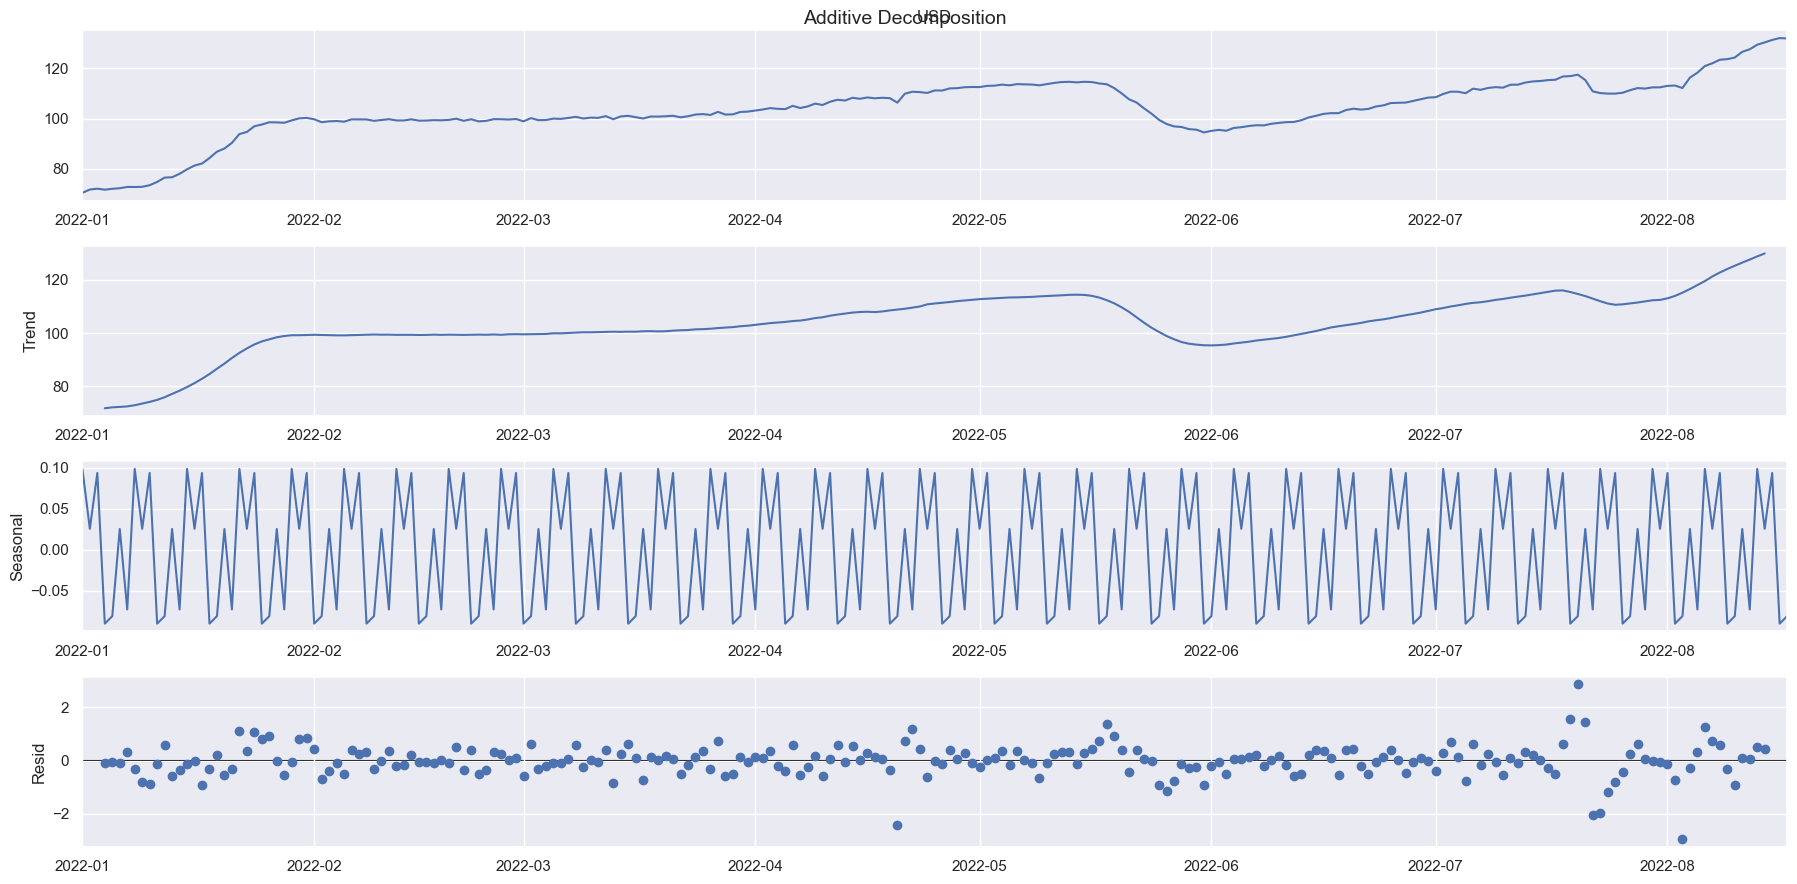

In [57]:
decomp = seasonal_decompose(new_df['USD'], model='additive')
decomp.plot().suptitle('Additive Decomposition', fontsize=14);

d:\pycharmprojects\tasainteres\env\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



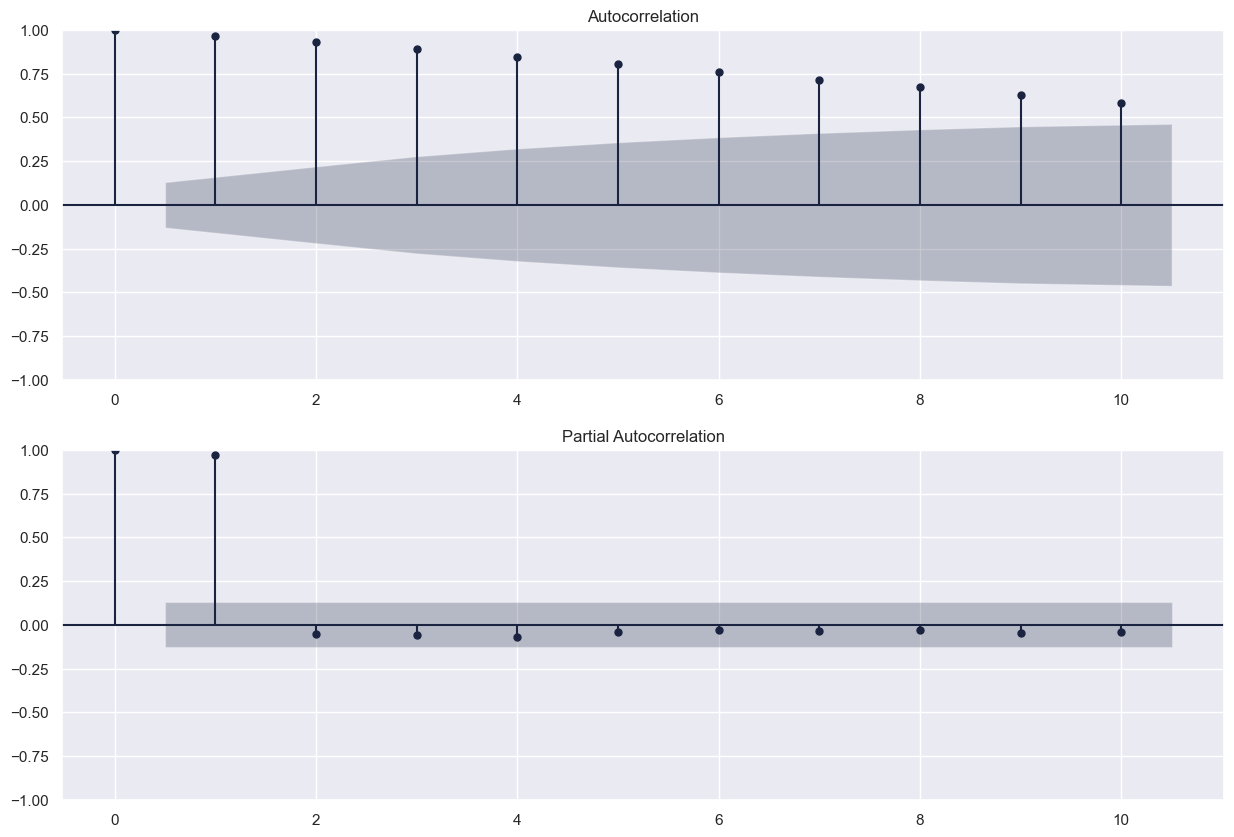

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(15,10))
plt.subplot(211)
plot_acf(new_df['USD'], ax=plt.gca(),lags=10)
plt.subplot(212)
plot_pacf(new_df['USD'], ax=plt.gca(),lags=10)
plt.show()

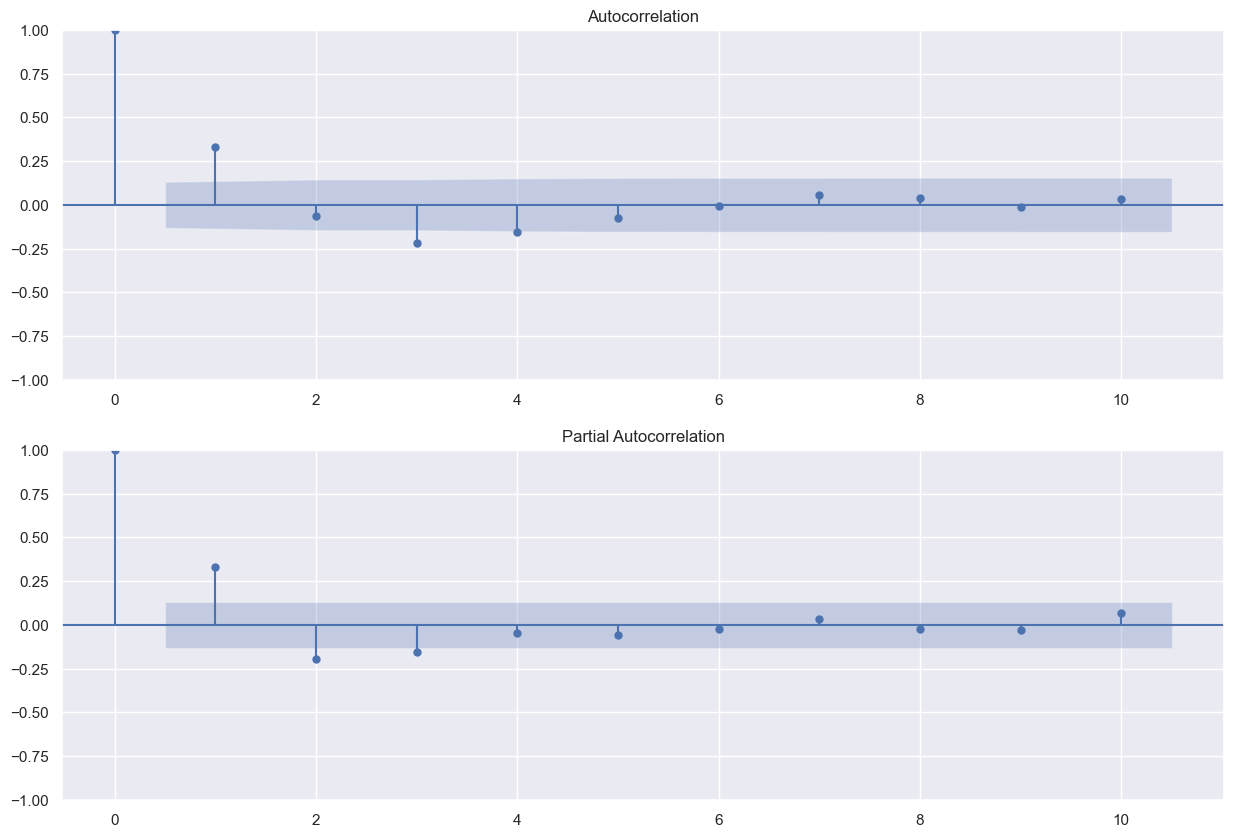

In [62]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(15,10))
plt.subplot(211)
plot_acf(decomp.resid.dropna(), ax=plt.gca(),lags=10)
plt.subplot(212)
plot_pacf(decomp.resid.dropna(), ax=plt.gca(),lags=10)
plt.show()

In [72]:
adfuller_test(decomp.resid.dropna(), name='USD Residual')

usd_diff = new_df['USD'].diff(1).dropna()
adfuller_test(usd_diff, name='USD Diff')
# usd_diff

Augmented Dickey-Fuller Test on "USD Residual" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -5.8782
No. Lags Chosen = 13
 Critical value 1%     = -3.462
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 5%     = -2.875
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 10%    = -2.574
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.

Augmented Dickey-Fuller Test on "USD Diff" 
    -----------------------------------------------
Null Hypothesis: Data has unit root. Non-Stationary.
Significance Level = 0.05
Test Statistic = -4.6249
No. Lags Chosen = 2
 Critical value 1%     = -3.46
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 5%     = -2.874
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.
 Critical value 10%    = -2.5

<AxesSubplot:xlabel='Date'>

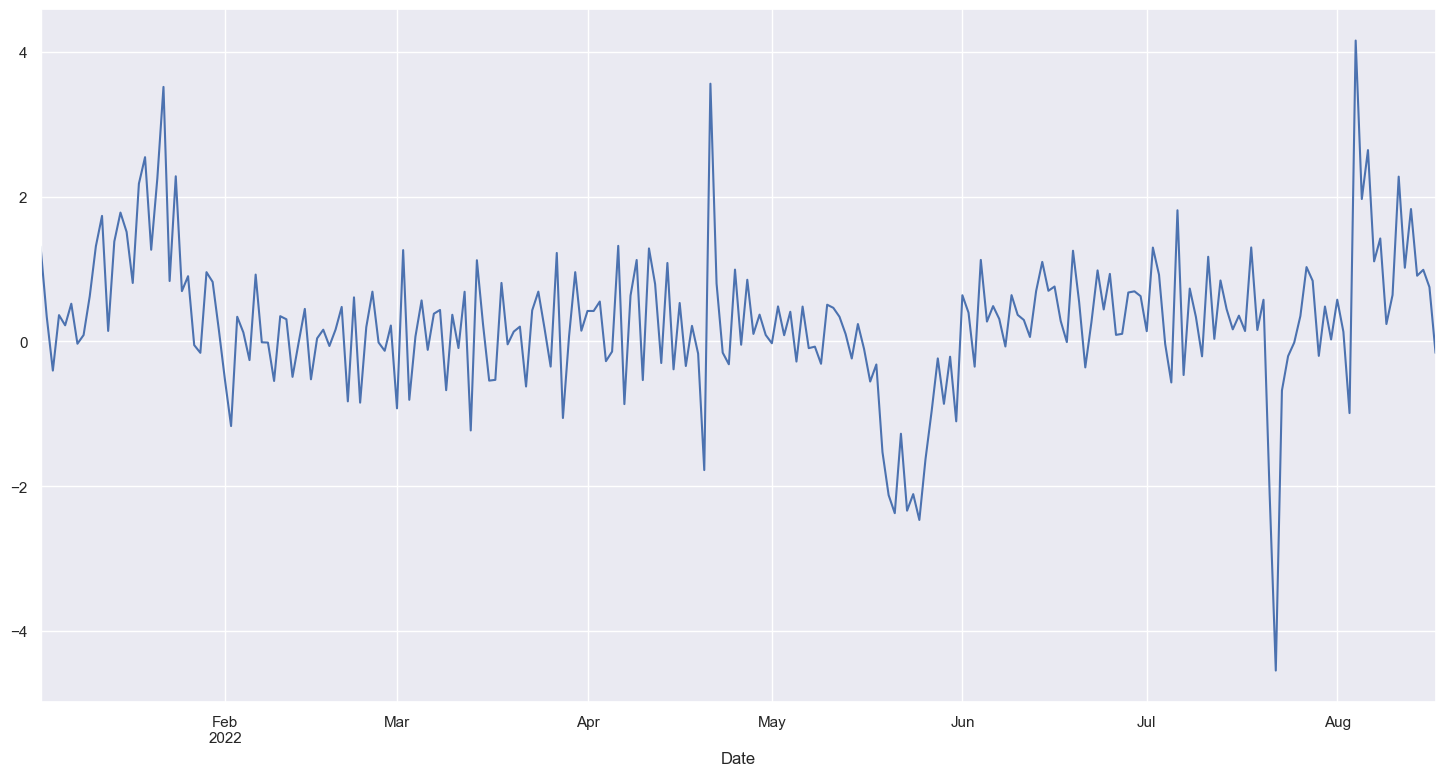

In [68]:
usd_diff.plot()

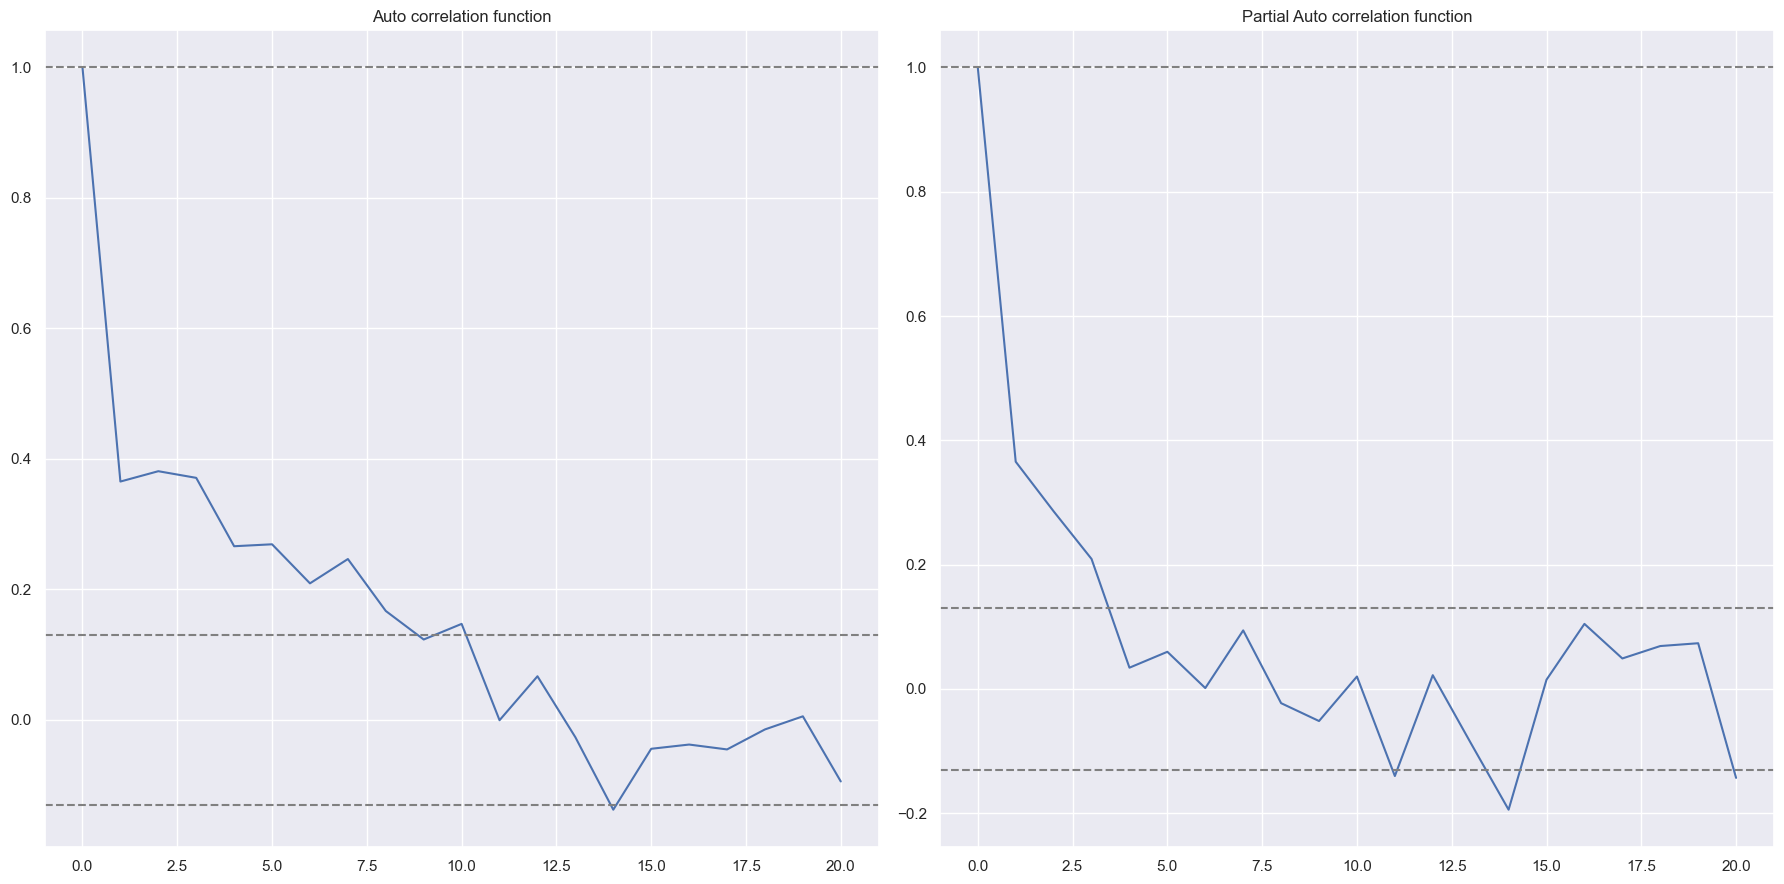

In [71]:
from statsmodels.tsa.stattools import acf, pacf
ret = new_df.diff().dropna()
lag_acf = acf(ret['USD'], nlags=20)
lag_pacf = pacf(ret['USD'], nlags=20, method = 'ols')
# plot acf
plt.subplot(121); plt.plot(lag_acf);
plt.axhline(y=1, linestyle='--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(ret)), linestyle='--', color = 'gray')
plt.axhline(y=1.96/np.sqrt(len(ret)), linestyle='--', color = 'gray')
plt.title('Auto correlation function')
# plot pacf
plt.subplot(122); plt.plot(lag_pacf);
plt.axhline(y=1, linestyle='--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(ret)), linestyle='--', color = 'gray')
plt.axhline(y=1.96/np.sqrt(len(ret)), linestyle='--', color = 'gray')
plt.title('Partial Auto correlation function'); plt.tight_layout();

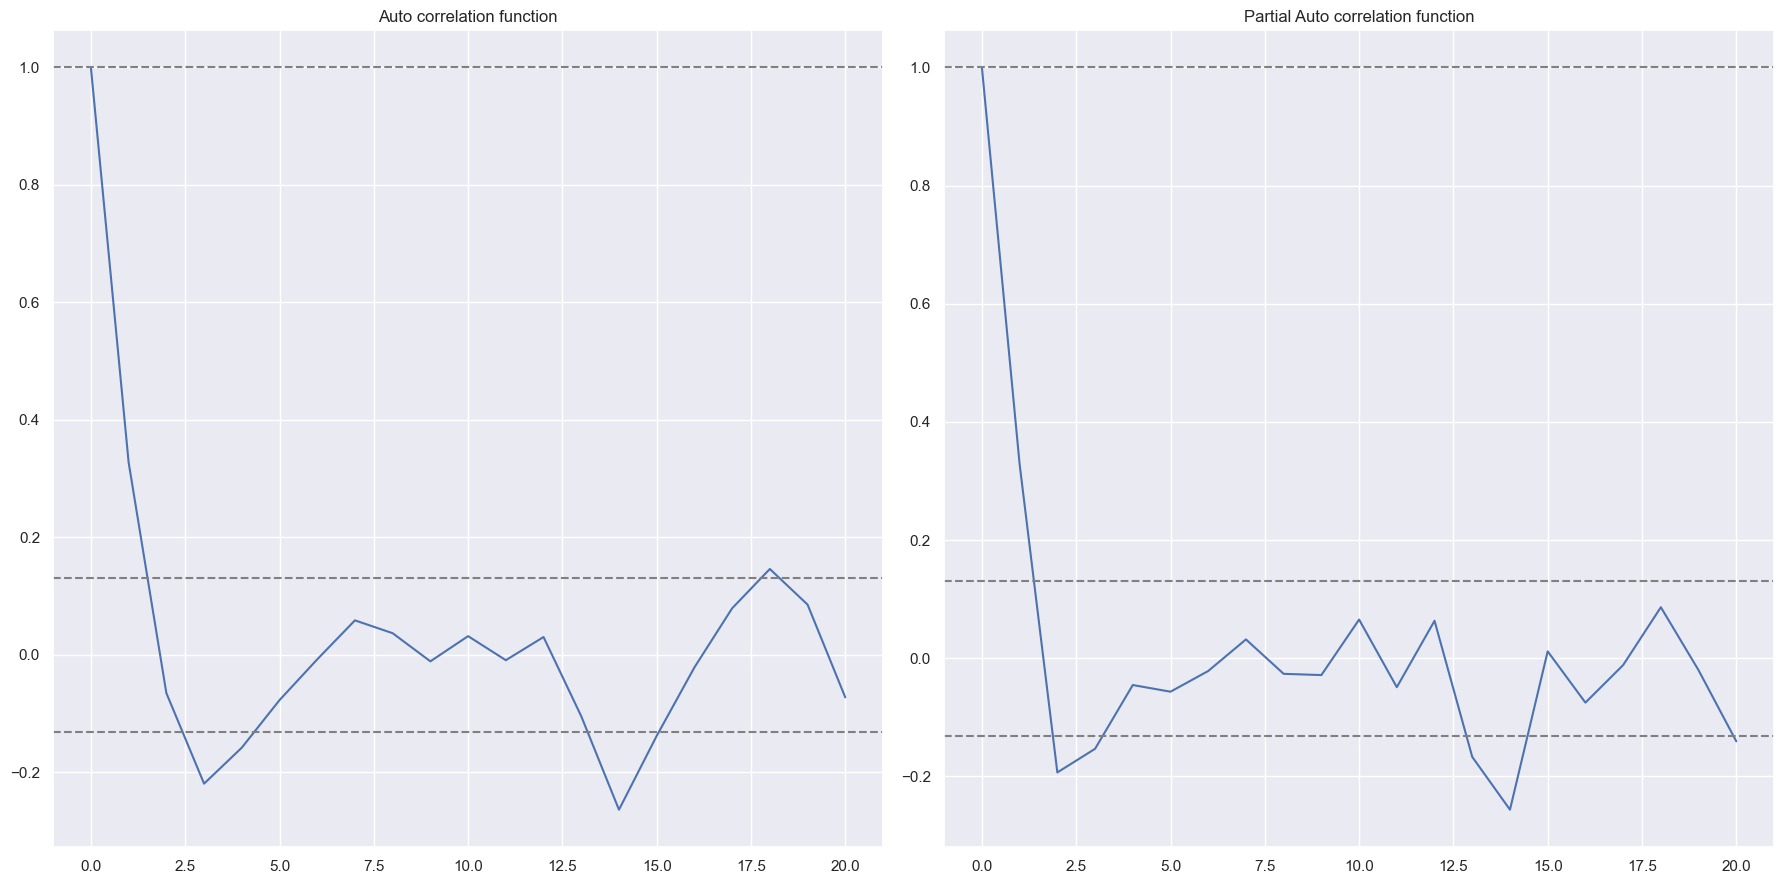

In [73]:
ret = decomp.resid.dropna()
lag_acf = acf(ret, nlags=20)
lag_pacf = pacf(ret, nlags=20, method = 'ols')
# plot acf
plt.subplot(121); plt.plot(lag_acf);
plt.axhline(y=1, linestyle='--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(ret)), linestyle='--', color = 'gray')
plt.axhline(y=1.96/np.sqrt(len(ret)), linestyle='--', color = 'gray')
plt.title('Auto correlation function')
# plot pacf
plt.subplot(122); plt.plot(lag_pacf);
plt.axhline(y=1, linestyle='--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(ret)), linestyle='--', color = 'gray')
plt.axhline(y=1.96/np.sqrt(len(ret)), linestyle='--', color = 'gray')
plt.title('Partial Auto correlation function'); plt.tight_layout();

In [94]:
from statsmodels.tsa.arima.model import ARIMA 
arima = ARIMA(new_df['USD'], order=(2, 1, 1)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    USD   No. Observations:                  229
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -289.273
Date:                Tue, 20 Sep 2022   AIC                            586.547
Time:                        15:21:30   BIC                            600.264
Sample:                    01-01-2022   HQIC                           592.081
                         - 08-17-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7633      0.133      5.726      0.000       0.502       1.025
ar.L2          0.1217      0.091      1.344      0.179      -0.056       0.299
ma.L1         -0.5671      0.123     -4.597      0.000      -0.809      -0.325
sigma2         0.7387      0.035     21.241      0.000       0.671       0.807
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               345.77
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.83   Skew:                             0.14
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

d:\pycharmprojects\tasainteres\env\lib\site-packages\ipykernel_launcher.py:13: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




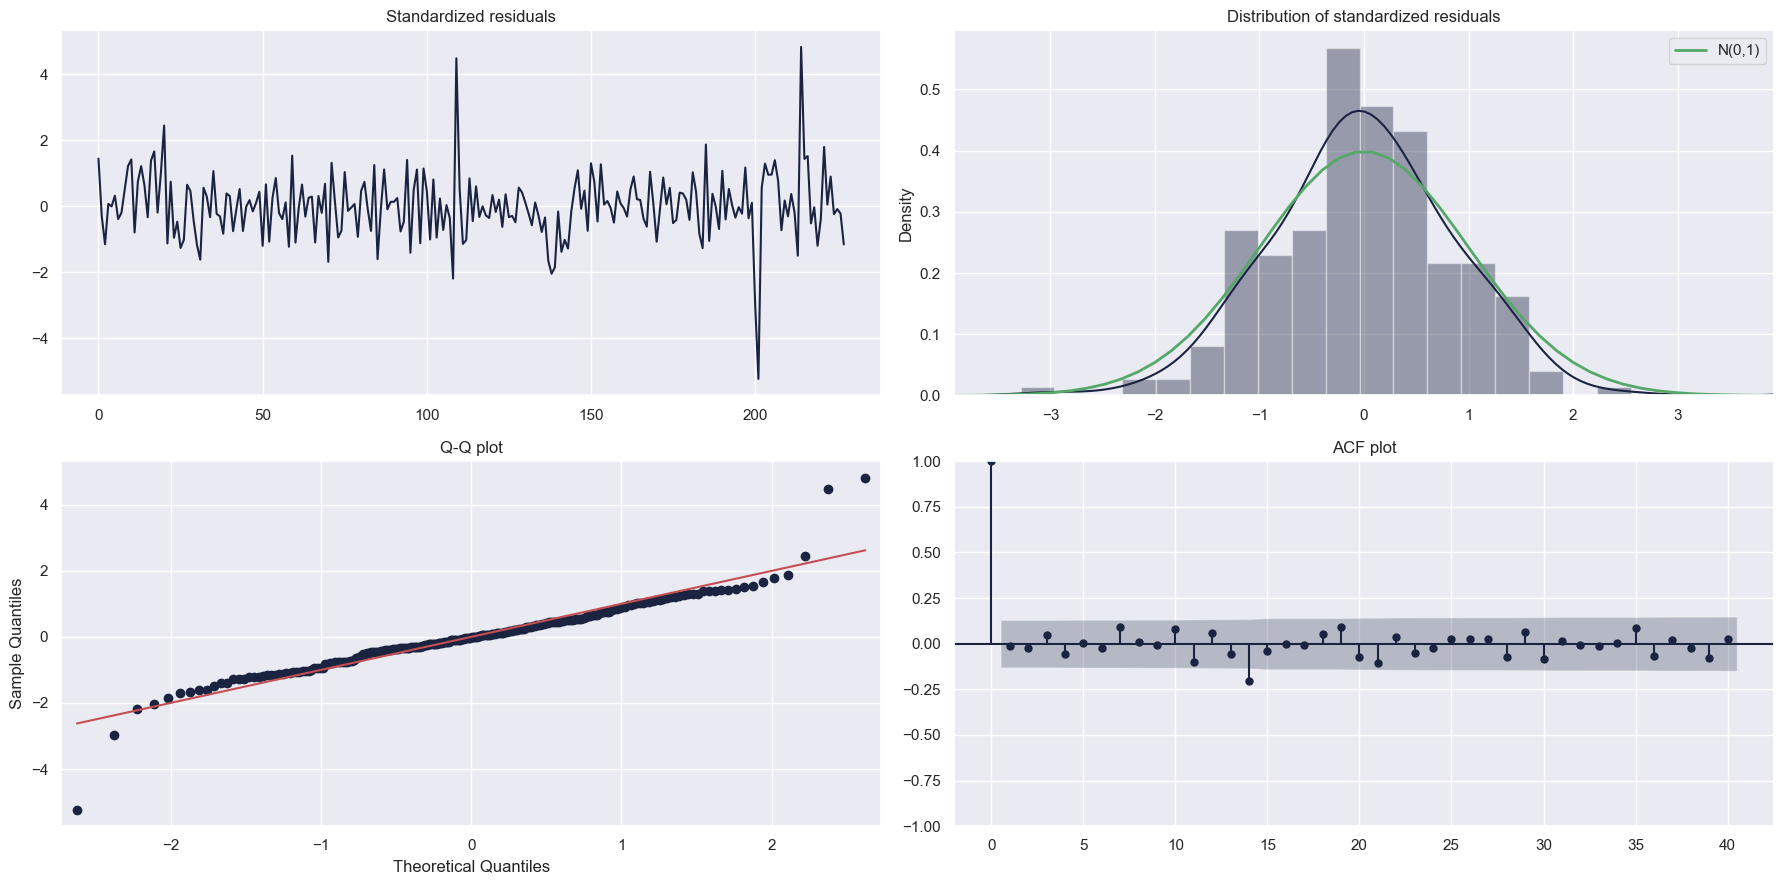

In [109]:
import scipy.stats as scs
import statsmodels.api as sm

def arima_diagnostics(resids, n_lags=40):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2);
    r = resids;  resids = (r - np.nanmean(r)) / np.nanstd(r);
    resids_nonmissing = resids[~(np.isnan(resids))];
    sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1);
    ax1.set_title('Standardized residuals');
    x_lim = (-1.96 * 2, 1.96 * 2);  
    r_range = np.linspace(x_lim[0], x_lim[1]);  
    norm_pdf = scs.norm.pdf(r_range);
    sns.distplot(resids_nonmissing, hist=True, kde=True,   norm_hist     =True, ax=ax2);
    ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)');
    ax2.set_title('Distribution of standardized residuals');
    ax2.set_xlim(x_lim); ax2.legend();
    # Q-Q plot
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3);
    ax3.set_title('Q-Q plot');
    # ACF plot
    plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05);
    ax4.set_title('ACF plot');
    return fig

arima_diagnostics(arima.resid[1:], 40); plt.tight_layout();

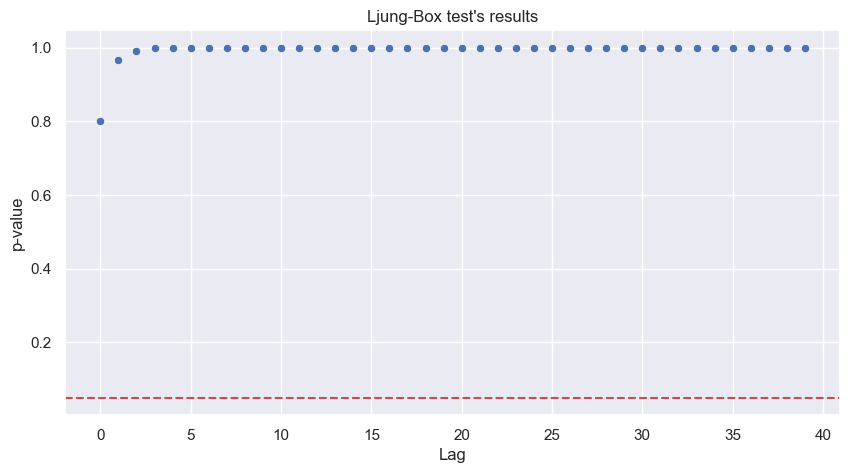

In [96]:
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung_box_results = acorr_ljungbox(arima.resid, lags=40)
fig, ax = plt.subplots(1, figsize=[10, 5])
sns.scatterplot(x=range(40), y=ljung_box_results[['lb_pvalue']].values.reshape((-1,)), ax=ax)
ax.axhline(0.05, ls='--', c='r')
ax.set(title="Ljung-Box test's results", xlabel='Lag', ylabel='p-value')
plt.show()

In [97]:
future = int(7)
forecast = arima.get_forecast(future)
std = forecast.var_pred_mean
arima_pred = forecast.predicted_mean
ci = forecast.conf_int(alpha=0.05)
arima_pred = pd.DataFrame(arima_pred)
d = pd.DataFrame(new_df['USD'].tail(future))
d.reset_index(inplace = True)
d = d.append(pd.DataFrame({'Date': pd.date_range(start = d.Date.iloc[-1], periods = (len(d)+1), freq = 'd', closed = 'right')}))
d = d.tail(future)
d.set_index('Date', inplace = True)
arima_pred.index = d.index
arima_pred.rename(columns = {0: 'arima_fcast'}, inplace=True)
# # 95% prediction interval
ci = pd.DataFrame(ci)
ci.rename(columns = {0: 'lower95', 1:'upper95'}, inplace=True)
ci.index = arima_pred.index
ar = pd.concat([arima_pred, ci], axis=1)
ar


,predicted_mean,lower USD,upper USD
Date,,,
2022-08-18,132.460345,130.775755,134.144935
2022-08-19,132.814572,130.187968,135.441176
2022-08-20,133.144591,129.537187,136.751994
2022-08-21,133.439628,128.834699,138.044557
2022-08-22,133.705015,128.088741,139.321288
2022-08-23,133.943510,127.308941,140.578080
2022-08-24,134.157869,126.503742,141.811997


<Figure size 1800x900 with 0 Axes>

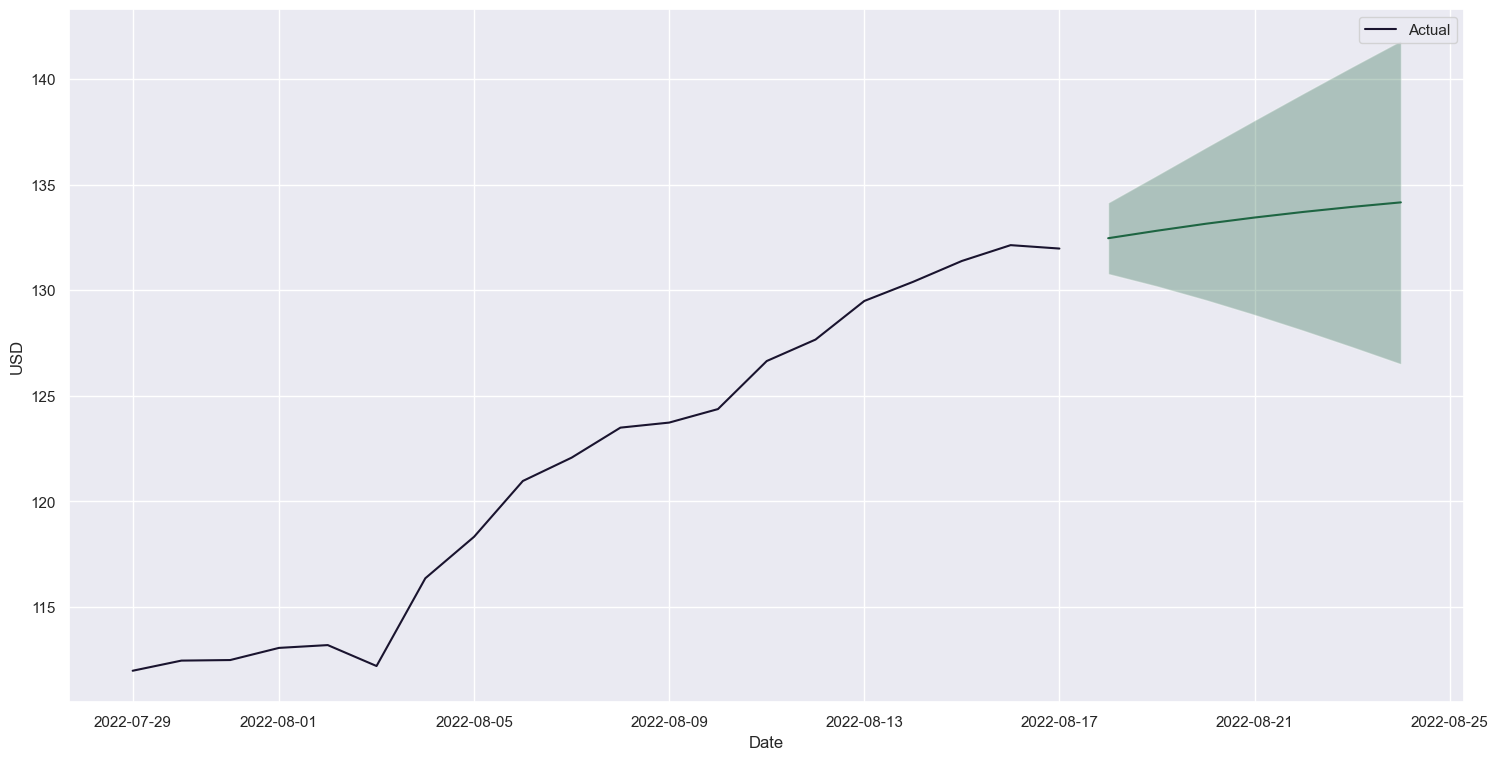

In [98]:
plt.set_cmap('cubehelix'); sns.set_palette('cubehelix')
COLORS = [plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]]; fig, ax = plt.subplots(1)
ax = sns.lineplot(data=new_df['USD'].tail(20), color=COLORS[0], label='Actual')
ax.plot(ar.predicted_mean, c=COLORS[1], label='ARIMA(2,1,7)')
ax.fill_between(ar.index, ar['lower USD'], ar['upper USD'], alpha=0.3, facecolor=COLORS[1])
# ax.plot(auto_arima_pred.prediction, c=COLORS[2], label='ARIMA(0,1,0)')
# ax.fill_between(auto_arima_pred.index, auto_arima_pred.ci_lower, auto_arima_pred.ci_upper,
#                 alpha=0.2, facecolor=COLORS[2])
# ax.set(title="Natural Gas price - historical and forecast", xlabel='Date', ylabel='Price ($)') 
# ax.legend(loc='best')

In [99]:
from pmdarima.arima import auto_arima

model = auto_arima(new_df['USD'], error_action='ignore', suppress_warnings=True,
                      seasonal=False)
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  229
Model:               SARIMAX(1, 1, 2)   Log Likelihood                -288.048
Date:                Tue, 20 Sep 2022   AIC                            586.097
Time:                        15:25:59   BIC                            603.244
Sample:                    01-01-2022   HQIC                           593.015
                         - 08-17-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0374      0.033      1.126      0.260      -0.028       0.103
ar.L1          0.8677      0.066     13.149      0.000       0.738       0.997
ma.L1         -0.6856      0.080     -8.612      0.000      -0.842      -0.530
ma.L2          0.1019      0.070      1.448      0.147      -0.036       0.240
sigma2         0.7312      0.035     21.182      0.000       0.664       0.799
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               352.31
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.84   Skew:                             0.12
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [100]:
auto_arima_pred = model.predict(n_periods=future, return_conf_int=True, alpha=0.05)
auto_arima_pred = [pd.DataFrame(auto_arima_pred[0], columns=['prediction']),
                   pd.DataFrame(auto_arima_pred[1], columns=['ci_lower', 'ci_upper'], index=auto_arima_pred[0].index)]
auto_arima_pred = pd.concat(auto_arima_pred,axis=1)
auto_arima_pred

,prediction,ci_lower,ci_upper
2022-08-18,132.503055,130.827127,134.178983
2022-08-19,132.905840,130.310883,135.500797
2022-08-20,133.292755,129.746634,136.838877
2022-08-21,133.665900,129.150769,138.181031
2022-08-22,134.027096,128.537188,139.517004
2022-08-23,134.377923,127.916452,140.839394
2022-08-24,134.719753,127.296386,142.143121


<Figure size 1800x900 with 0 Axes>

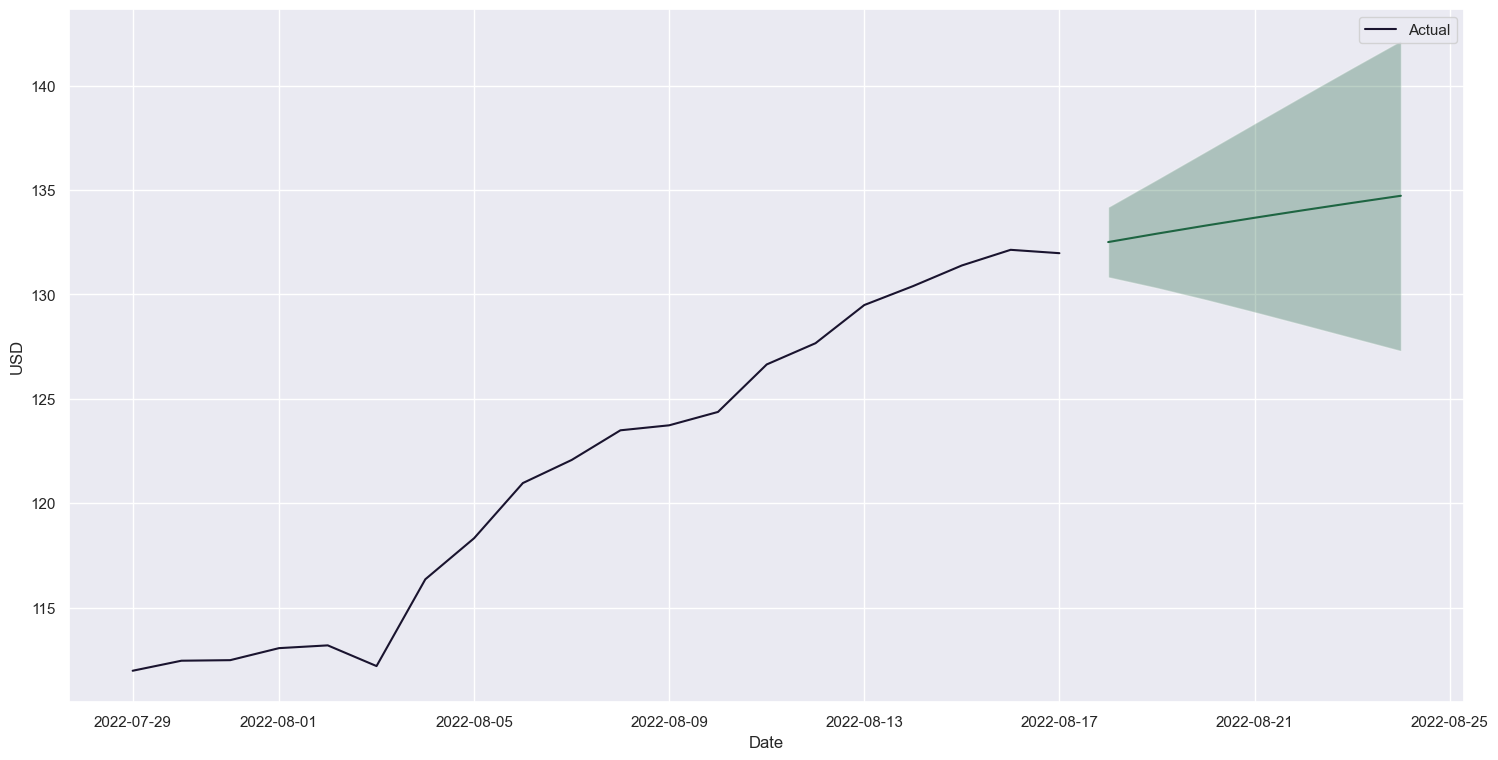

In [101]:
plt.set_cmap('cubehelix'); sns.set_palette('cubehelix')
COLORS = [plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]]; fig, ax = plt.subplots(1)
ax = sns.lineplot(data=new_df['USD'].tail(20), color=COLORS[0], label='Actual')
ax.plot(auto_arima_pred.prediction, c=COLORS[1], label='AUTO ARIMA(1,1,2)')
ax.fill_between(auto_arima_pred.index, auto_arima_pred.ci_lower, auto_arima_pred.ci_upper, alpha=0.3, facecolor=COLORS[1])


<AxesSubplot:ylabel='Density'>

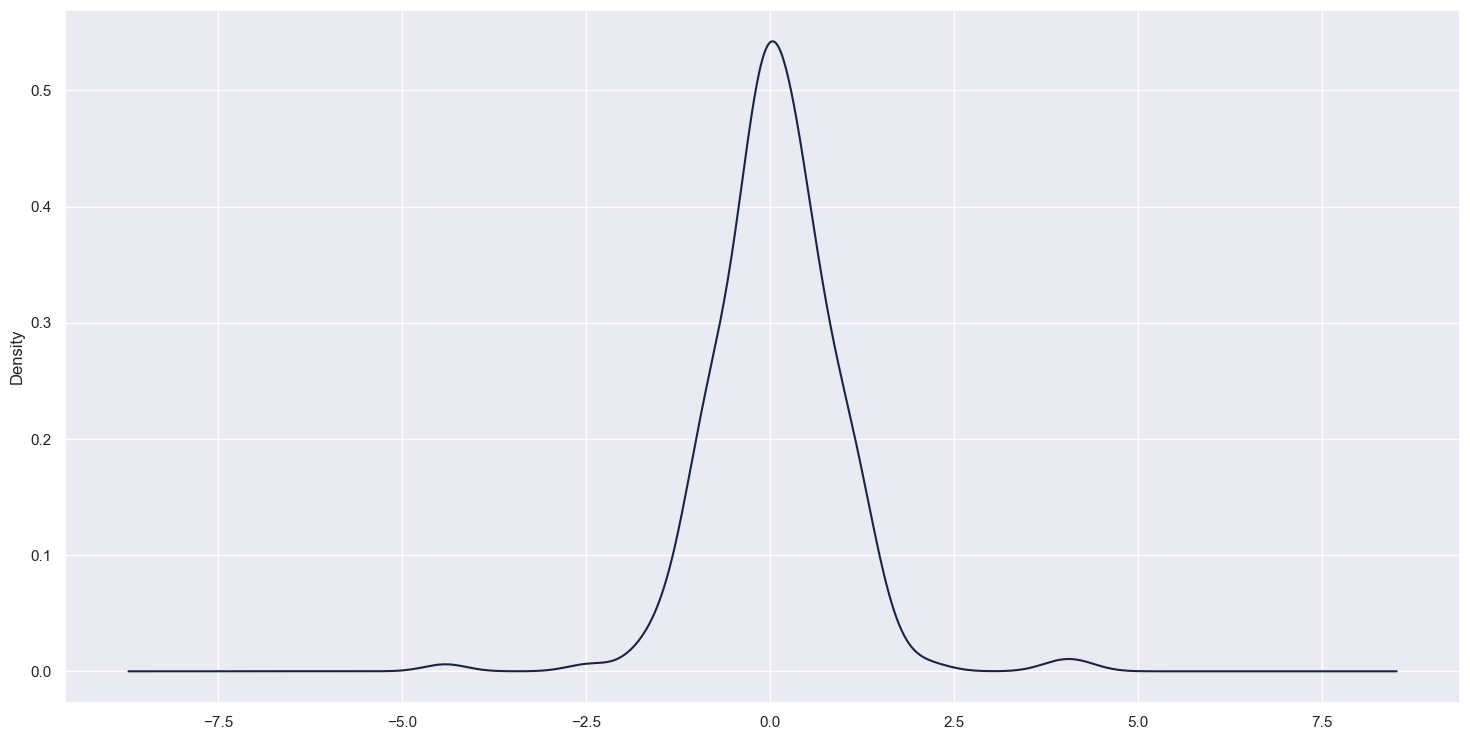

In [108]:
arima.resid[1:].plot(kind='kde')

(229, 3)